# Overview

- Want to use laser distance measurement device, Bosch GLM 165-40 (https://www.boschtools.com/us/en/boschtools-ocs/laser-measures-glm165-40-187965-p/)
- This device only measures distance, so to locate the 3D coordinates of a point in space, e.g. the NMR in the magnet, distance measurements from >=4 locations with known positions are required.
- Testing here the feasibility of this strategy and developing code for calculations.
- If Bosch device is not sufficient, we are also considering something like the Leica Disto 2910 and TRI 200 Pro Pack (https://www.engineersupply.com/Leica-DISTO-S910-and-TRI-200-Pro-Pack-6010741.aspx)

# Imports

In [1]:
import numpy as np
import lmfit as lm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
# %matplotlib inline
%matplotlib notebook

from plotting import config_plots
config_plots()

# Playground

## First Attempt

In [2]:
75/2, 250/2, np.cos(np.pi/4)*250/2

(37.5, 125.0, 88.38834764831844)

In [3]:
#stations = np.array([[-1, -1, -1],[1, 1, 1],[-1, 1, 1],[1, -1, -1]])
#stations = np.array([[-1, -1, -1],[1, 1, 1],[-1, 1, 1],[1, -1, 1]])
##stations = np.array([[37.5, 0, 125.0], [37.5, -125.0, 0], [37.5, 0, -125.0], [37.5, 125.0, 0]])
##stations = np.array([[37.5, 0, 125.0], [37.5, -125.0, 0], [37.5, 0, -125.0], [37.5, 125.0, 0], [-37.5, 0, 125.0]])
##stations = np.array([[37.5, 0, -125.0], [37.5, 125.0, 0], [-37.5, 0, 125.0], [37.5, -125.0, 0]])
stations = np.array([[37.5, 0, 125.0], [37.5, -125.0, 0], [37.5, 0, -125.0], [37.5, 125.0, 0], [37.5, 88.4, 88.4]])

In [4]:
stations.shape

(5, 3)

In [5]:
#test_point = np.array([-0.1, 0., 0.5])
#test_point = np.random.uniform(low=-1, high=1, size=3)
x = np.random.uniform(low=-37.5, high=37.5)
theta = np.random.uniform(low=0, high=2*np.pi)
r = 125.0*(np.random.rand())**(1/2)
y = r*np.cos(theta)
z = r*np.sin(theta)
test_point = np.array([x, y, z])

In [6]:
test_point

array([-20.80514274, 101.33087946,  34.23476476])

In [7]:
station_meas = np.linalg.norm(np.subtract(stations, test_point), axis=1)

In [8]:
station_meas

array([148.0059618 , 236.21425821, 197.54277286,  71.63613652,
        80.62611253])

In [9]:
# station_meas_noise = station_meas + np.random.normal(loc=0, scale=2e-3, size=len(station_meas))
station_meas_noise = station_meas + np.random.normal(loc=0, scale=2, size=len(station_meas))

In [10]:
station_meas_noise

array([145.81713228, 238.68168242, 194.86710474,  74.08376465,
        80.06475775])

## Least-Squares - Easy Solution

In [11]:
def dist2loc(stations, **params):
    x0 = params['x0']
    y0 = params['y0']
    z0 = params['z0']
    test_point = np.array([x0, y0, z0])
    return np.linalg.norm(np.subtract(stations, test_point), axis=1)

In [12]:
model = lm.Model(dist2loc, independent_vars=['stations'])
params = lm.Parameters()
# params.add('x0', value=0, vary=True, min=-1, max=1)
# params.add('y0', value=0, vary=True, min=-1, max=1)
# params.add('z0', value=0, vary=True, min=-1, max=1)

params.add('x0', value=0, vary=True, min=-37.5, max=37.5)
params.add('y0', value=0, vary=True, min=-125., max=125.)
params.add('z0', value=0, vary=True, min=-125., max=125.)

#result = model.fit(station_meas, stations=stations, params=params)
# result = model.fit(station_meas_noise, stations=stations, params=params, weights=1/(2e-3*np.ones_like(station_meas_noise)))
result = model.fit(station_meas_noise, stationss=stations, params=params, weights=1/(2*np.ones_like(station_meas_noise)))

/home/ckampa/anaconda3/envs/mu2e/lib/python3.8/site-packages/lmfit/model.py:968: UserWarning: The keyword argument stationss does not match any arguments of the model function. It will be ignored.
  warnings.warn("The keyword argument %s does not " % name +


KeyError: 'stations'

In [13]:
result

NameError: name 'result' is not defined

In [14]:
test_point

array([-20.80514274, 101.33087946,  34.23476476])

In [15]:
fit_point = np.array([result.params[f'{i}0'].value for i in ['x','y','z']])

NameError: name 'result' is not defined

In [16]:
fit_point

NameError: name 'fit_point' is not defined

In [17]:
np.linalg.norm(fit_point - test_point)

NameError: name 'fit_point' is not defined

## Make a function:

In [18]:
def loc2dist(stations, **params):
    x0 = params['x0']
    y0 = params['y0']
    z0 = params['z0']
    test_point = np.array([[x0, y0, z0]])
    return np.linalg.norm(np.subtract(stations, test_point), axis=1)

In [19]:
s_ = np.array([[-10, 0, 0]])
t_ = np.array([[0, 0, 0]])
td = {'x0': t_[0,0], 'y0': t_[0,1], 'z0': t_[0,2]}
loc2dist(s_, **td)

array([10.])

In [20]:
np.linalg.norm(np.subtract(s_, t_), axis=1)

array([10.])

In [21]:
def generate_test_points_GMW(N=1):
    x = np.random.uniform(low=-37.5, high=37.5, size=N)
    theta = np.random.uniform(low=0, high=2*np.pi, size=N)
    r = 125.0*(np.random.rand(N))**(1/2)
    y = r*np.cos(theta)
    z = r*np.sin(theta)
    #if N > 1:
    test_points = np.array([x, y, z]).T
    #else:
    #    test_points = np.array([[]])
    return test_points

In [22]:
def triangulate_GMW(test_point, stations, noise_level=2, init_vals=[0.,0.,0.], vary_z=True):
    station_meas = np.linalg.norm(np.subtract(stations, test_point), axis=1)
    station_meas_noise = station_meas + np.random.normal(loc=0, scale=noise_level, size=len(station_meas))
    model = lm.Model(loc2dist, independent_vars=['stations'])
    params = lm.Parameters()

    params.add('x0', value=init_vals[0], vary=True, min=-37.5, max=37.5)
    params.add('y0', value=init_vals[1], vary=True, min=-125., max=125.)
    params.add('z0', value=init_vals[2], vary=vary_z, min=-125., max=125.)

    result = model.fit(station_meas_noise, stations=stations, params=params,
                       weights=1/(noise_level*np.ones_like(station_meas_noise)),
                       #weights=1/(station_meas_noise),
                       method='least_squares')
    fit_point = np.array([result.params[f'{i}0'].value for i in ['x', 'y', 'z']])
    
    return fit_point, result, station_meas, station_meas_noise

def triangulate_GMW_grid(test_point, stations, noise_level=2,
                         xs=np.linspace(-37.5, 37.5, 751),
                         ys=np.linspace(-125., 125., 250),
                         zs=np.linspace(-125., 125., 250)):
    station_meas = np.linalg.norm(np.subtract(stations, test_point), axis=1)
    station_meas_noise = station_meas + np.random.normal(loc=0, scale=noise_level, size=len(station_meas))
    
    x_grid = []; y_grid = []; z_grid = []
    misfit_grid = []
    misfit_grid_noise = []
    
    for x in xs:
        for y in ys:
            for z in zs:
                #misfit = np.linalg.norm(loc2dist(stations, x0=x, y0=y, z0=z)-station_meas_noise)**2/noise_level**2
                misfit_n = np.linalg.norm(loc2dist(stations, x0=x, y0=y, z0=z)-station_meas_noise)
                misfit_grid_noise.append(misfit_n)
                misfit = np.linalg.norm(loc2dist(stations, x0=x, y0=y, z0=z)-station_meas)
                misfit_grid.append(misfit)
                x_grid.append(x)
                y_grid.append(y)
                z_grid.append(z)
    return np.array(misfit_grid), np.array(misfit_grid_noise),\
           np.array(x_grid), np.array(y_grid), np.array(z_grid),\
           station_meas, station_meas_noise

In [23]:
#stations = np.array([[-1, -1, -1],[1, 1, 1],[-1, 1, 1],[1, -1, -1]])
#stations = np.array([[-1, -1, -1],[1, 1, 1],[-1, 1, 1],[1, -1, 1]])

# stations = np.array([[37.5, 0, 125.0], [37.5, -125.0, 0], [37.5, 0, -125.0], [37.5, 125.0, 0]])
# stations2 = np.array([[-37.5, 0, 125.0], [-37.5, -125.0, 0], [-37.5, 0, -125.0], [-37.5, 125.0, 0],])

stations = np.array([[37.5, 0, 250.0], [37.5, -125.0, 0], [37.5, 0, -125.0], [37.5, 200.0, 0]])


#stations = np.array([[37.5, 0, 125.0], [37.5, -125.0, 0], [37.5, 0, -125.0], [37.5, 125.0, 0], [-37.5, 0, 125.0]])
# stations = np.array([[37.5, 0, -125.0], [37.5, 125.0, 0], [-37.5, 0, 125.0], [37.5, -125.0, 0]])
# stations = np.array([[37.5, 0, 125.0], [37.5, -125.0, 0], [37.5, 0, -125.0], [37.5, 125.0, 0], [37.5, 88.4, 88.4]])
# stations = np.array([[37.5, 0, 125.0], [37.5, -125.0, 0], [37.5, 0, -125.0], [37.5, 125.0, 0],
#                      [-37.5, 88.4, 88.4], [-37.5, 88.4, -88.4], [-37.5, -88.4, -88.4], [-37.5, -88.4, 88.4],])
# stations = np.array([[37.5, 0, 125.0], [37.5, -125.0, 0], [37.5, 0, -125.0], [37.5, 125.0, 0],
#                      [-37.5, 0, 125.0], [-37.5, -125.0, 0], [-37.5, 0, -125.0], [-37.5, 125.0, 0],
#                      [-37.5, 88.4, 88.4], [-37.5, 88.4, -88.4], [-37.5, -88.4, -88.4], [-37.5, -88.4, 88.4],
#                      [37.5, 88.4, 88.4], [37.5, 88.4, -88.4], [37.5, -88.4, -88.4], [37.5, -88.4, 88.4],
#                      [0, 88.4, 88.4]
#                     ])

In [24]:
test_points = generate_test_points_GMW(1000)

### TESTING

In [25]:
i = 1
_ =  triangulate_GMW_grid(test_points[i], stations, noise_level=2,
                                            xs=np.linspace(-37.5, 37.5, 10),#76),
                                            ys=np.linspace(-125., 125., 10),#250),
                                            zs=np.linspace(-125., 125., 10))#250))
mg, mgn, xg, yg, zg, meas, meas_n = _

In [26]:
meas, meas_n

(array([248.3254772 , 181.48634719, 148.25913076, 150.3123435 ]),
 array([248.6985431 , 186.01035422, 146.88077773, 152.14276517]))

In [27]:
mg, mgn

(array([259.59358126, 242.37812451, 230.56218625, 223.86625891,
        220.90837618, 220.03837441, 221.52728282, 227.5384584 ,
        239.76416369, 258.36418565, 236.22387129, 217.52812842,
        203.97155753, 195.6380221 , 191.55669225, 190.42736541,
        192.68209241, 200.44761406, 215.22290451, 236.79817205,
        216.37234555, 195.29821543, 178.47421656, 166.69507007,
        160.08447851, 158.37660147, 162.25922769, 173.26419489,
        192.0435521 , 217.67726884, 200.20683201, 176.08505713,
        154.72457358, 137.90071436, 127.4268009 , 124.73304724,
        130.99341773, 146.62452276, 170.62599318, 201.01743296,
        187.12052124, 159.73747672, 133.32776256, 110.37532294,
         94.61958505,  90.44235497, 100.2014843 , 121.92874319,
        151.857248  , 186.97369128, 176.17831767, 145.87939569,
        115.1036129 ,  85.94379998,  63.16972254,  56.7218436 ,
         72.41520763, 101.68169869, 137.20554066, 176.02236046,
        168.23947954, 135.96043075, 102.

In [28]:
ts = np.linspace(0, 2*np.pi, 100)
xs_n = -37.5 * np.ones_like(ts)
xs_p = 37.5 * np.ones_like(ts)
ys = 125 * np.cos(ts)
zs = 125 * np.sin(ts)
verts_n = [list(zip(xs_n, ys, zs))]
verts_p = [list(zip(xs_p, ys, zs))]

<IPython.core.display.Javascript object>


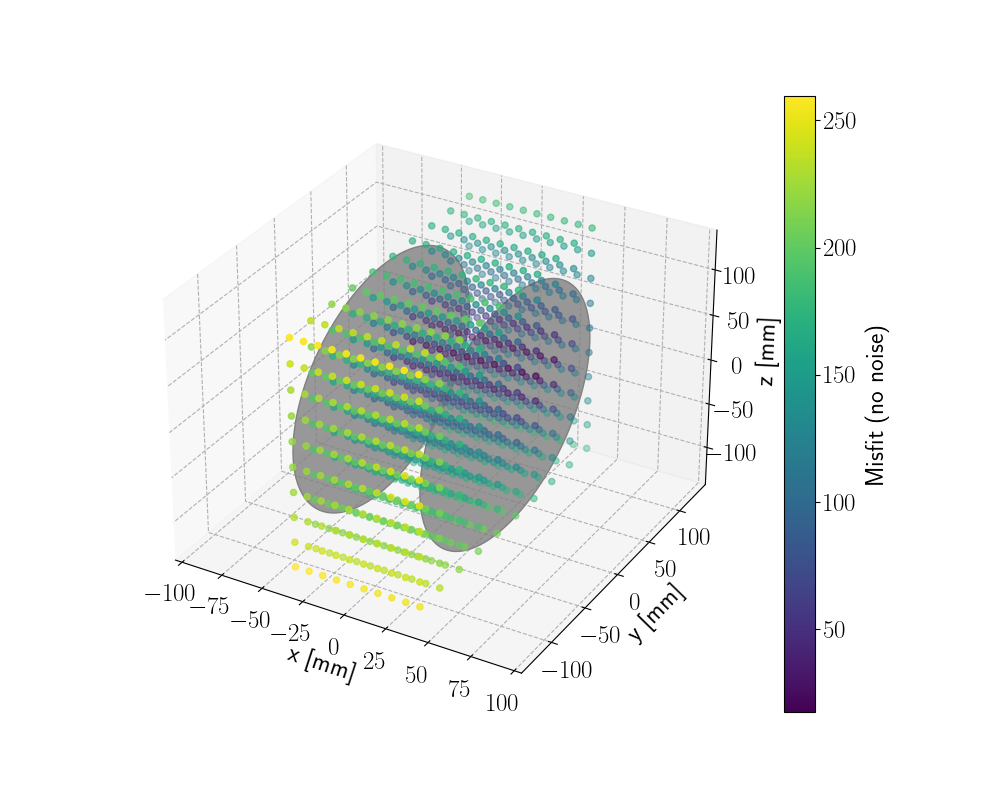

<IPython.core.display.Javascript object>


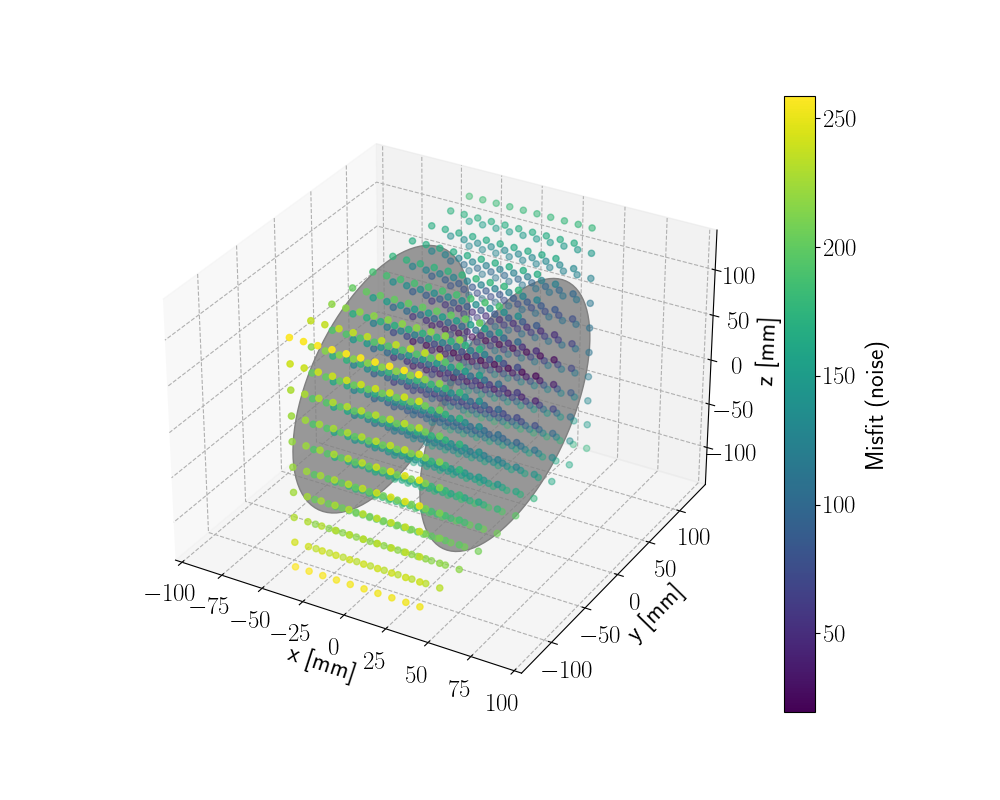

In [29]:
for m_, na in zip([mg, mgn], [' (no noise)', ' (noise)']):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    sc = ax.scatter(xg, yg, zg, c=m_)
    cb = fig.colorbar(sc, label=f'Misfit{na}')

    ax.add_collection3d(Poly3DCollection(verts_n, color='gray', alpha=0.8))#, zs='z')
    ax.add_collection3d(Poly3DCollection(verts_p, color='gray', alpha=0.8))

    # ax.set_aspect('equal')
    ax.set_xlim3d([-100, 100])

    # ax.plot_trisurf(xs_n, ys, zs, color='red', edgecolor='none');

    ax.set_xlabel('x [mm]')
    ax.set_ylabel('y [mm]')
    ax.set_zlabel('z [mm]');

In [30]:
test_points[i]

array([ 5.6540941 , 53.41306709,  9.58696963])

In [31]:
imin = np.argmin(mg)

In [32]:
mg[imin]

17.478906755729383

In [33]:
xg[imin], yg[imin], zg[imin]

(4.166666666666671, 41.666666666666686, 13.888888888888886)

In [34]:
_ = triangulate_GMW(test_points[i], stations, init_vals=[x_, y_, z_])
fit_point, result, station_meas, staion_meas_noise = _
#print(init_x, fit_point, test_points[i], result.redchi)
print(f'{x_:.1f}, {y_:.1f}, {z_:.1f}', fit_point, test_points[i], result.redchi)

NameError: name 'x_' is not defined

In [35]:
loc2dist(stations, x0=test_points[i][0], y0=test_points[i][1], z0=test_points[i][2])\
-loc2dist(stations, x0=test_points[i][0]+0.1, y0=test_points[i][1]-1, z0=test_points[i][2]-1)

array([-0.74315465,  1.05094334,  1.28834931, -0.89427459])

In [36]:
loc2dist(stations, x0=test_points[i][0], y0=test_points[i][1], z0=test_points[i][2])

array([248.3254772 , 181.48634719, 148.25913076, 150.3123435 ])

In [37]:
meas

array([248.3254772 , 181.48634719, 148.25913076, 150.3123435 ])

In [38]:
np.linalg.norm(np.subtract(stations, test_points[i]), axis=1)

array([248.3254772 , 181.48634719, 148.25913076, 150.3123435 ])

In [39]:
loc2dist(stations, x0=test_points[i][0], y0=test_points[i][1], z0=test_points[i][2])

array([248.3254772 , 181.48634719, 148.25913076, 150.3123435 ])

In [40]:
250*250*76

4750000

In [41]:
stations

array([[  37.5,    0. ,  250. ],
       [  37.5, -125. ,    0. ],
       [  37.5,    0. , -125. ],
       [  37.5,  200. ,    0. ]])

In [42]:
test_points[1]

array([ 5.6540941 , 53.41306709,  9.58696963])

In [43]:
station_meas

array([148.0059618 , 236.21425821, 197.54277286,  71.63613652,
        80.62611253])

In [44]:
i = 2
N = 10
ixs = np.random.uniform(low=-37.5, high=37.5, size=N)
theta = np.random.uniform(low=0, high=2*np.pi, size=N)
r = 125.0*(np.random.rand(N))**(1/2)
iys = r*np.cos(theta)
izs = r*np.sin(theta)
# for init_x in [-30, -15, 0, 15, 30]:
for x_, y_, z_ in zip(ixs, iys, izs):
#     _ = triangulate_GMW(test_points[i], stations, init_vals=[init_x, 0, 0])
    _ = triangulate_GMW(test_points[i], stations, init_vals=[x_, y_, z_])#, noise_level= 1.5875)
    fit_point, result, station_meas, staion_meas_noise = _
    #print(init_x, fit_point, test_points[i], result.redchi)
    print(f'{x_:.1f}, {y_:.1f}, {z_:.1f}', fit_point, test_points[i], result.redchi)

15.1, -21.3, 117.4 [ 37.5        -34.70230285 -52.97810266] [ 37.06499177 -34.83419539 -52.40026828] 0.676728053392466
-37.4, -45.2, -72.5 [ 25.12618918 -35.01461134 -51.10445124] [ 37.06499177 -34.83419539 -52.40026828] 0.006150929302847968
27.8, -51.7, 103.4 [ 37.5        -32.69562565 -51.94110562] [ 37.06499177 -34.83419539 -52.40026828] 0.4789099892857451
10.7, -0.6, 112.8 [ 19.30253642 -36.50616062 -52.86447242] [ 37.06499177 -34.83419539 -52.40026828] 1.2829030195475002
34.7, 116.0, 20.3 [ 23.50522674 -35.45370843 -53.94350994] [ 37.06499177 -34.83419539 -52.40026828] 0.39185987750807993
-17.2, -0.5, -65.5 [ 35.92712677 -33.55526022 -50.87424157] [ 37.06499177 -34.83419539 -52.40026828] 0.16457758465939842
-32.5, 91.9, -48.5 [ 17.94304015 -34.01964781 -53.20681571] [ 37.06499177 -34.83419539 -52.40026828] 0.41368808435229554
13.5, 78.0, 86.5 [ 34.1224436  -33.73692023 -53.24989168] [ 37.06499177 -34.83419539 -52.40026828] 0.1464513419848364
21.7, 75.8, -52.6 [ 37.5        -34.810

### Working

In [45]:
#i = 2

misfit_dists = []
mis_xs = []; mis_ys = []; mis_zs = []

# for init_x in [-30, -15, 0, 15, 30]:
#for x_, y_, z_ in zip(ixs, iys, izs):
for i in range(len(test_points)):
#     _ = triangulate_GMW(test_points[i], stations, init_vals=[init_x, 0, 0])
#     _ = triangulate_GMW(test_points[i], stations, init_vals=[0, 0, 0])
    
    sta = stations
    
#     if test_points[i][0] < 0:
#         sta = stations
#     else:
#         sta = stations2

    _ = triangulate_GMW(test_points[i], sta, init_vals=[0, 0, 0], noise_level=1.5875)
    fit_point, result, station_meas, staion_meas_noise = _
    diffs = fit_point-test_points[i]
    mis_xs.append(diffs[0])
    mis_ys.append(diffs[1])
    mis_zs.append(diffs[2])
    misfit_dist = np.linalg.norm(diffs)
    misfit_dists.append(misfit_dist)
    #print(init_x, fit_point, test_points[i], result.redchi)
#     print(f'{i}', fit_point, test_points[i], result.redchi)
misfit_dists = np.array(misfit_dists)
mis_xs = np.array(mis_xs)
mis_ys = np.array(mis_ys)
mis_zs = np.array(mis_zs)

In [46]:
np.mean(misfit_dists), np.std(misfit_dists)

(4.216683819425574, 3.446844672699294)

In [47]:
np.mean(mis_xs), np.std(mis_xs)

(0.20720484782290194, 5.155067961867642)

In [48]:
np.mean(mis_ys), np.std(mis_ys)

(-0.026612304311406734, 1.2429760980130895)

In [49]:
np.mean(mis_zs), np.std(mis_zs)

(0.038529363424011066, 1.2232410978490584)

In [50]:
np.max(np.abs(mis_xs)), np.max(np.abs(mis_ys)), np.max(np.abs(mis_zs))

(25.626664389690276, 5.126793952710457, 4.448705477189776)

<IPython.core.display.Javascript object>


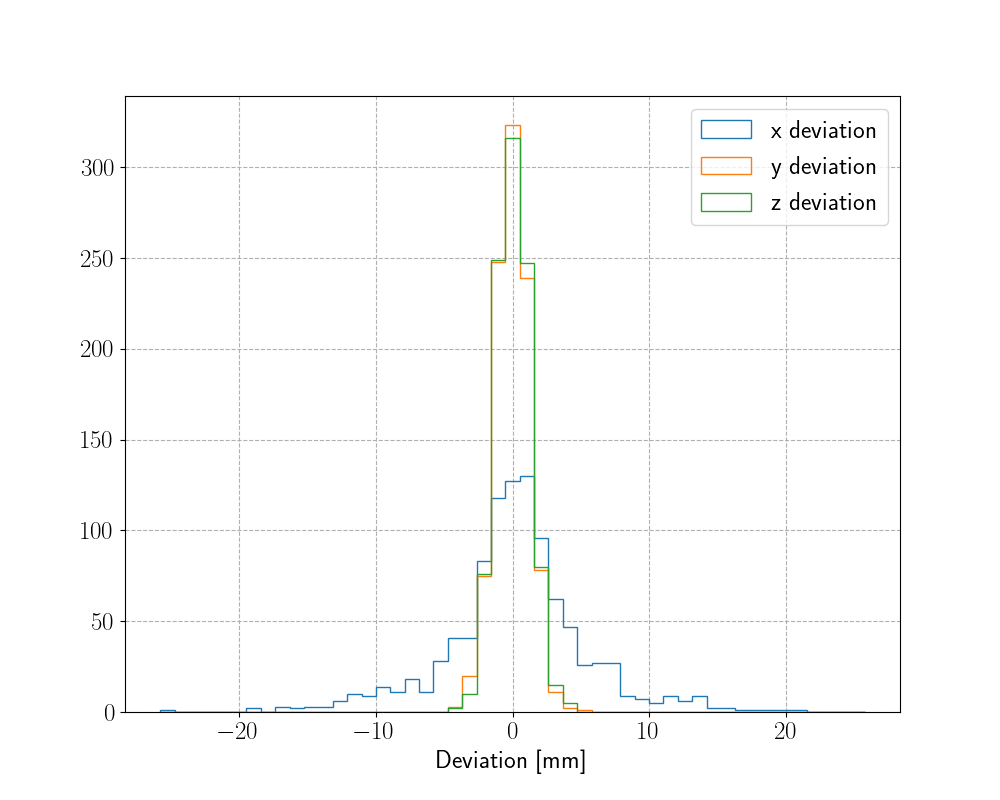

In [51]:
fig, ax = plt.subplots()

dmax = 0.1 + np.max([np.max(np.abs(mis_xs)), np.max(np.abs(mis_ys)), np.max(np.abs(mis_zs))])
bins = np.linspace(-dmax, dmax, 50)

ax.hist(mis_xs, histtype='step', bins=bins, label='x deviation')
ax.hist(mis_ys, histtype='step', bins=bins, label='y deviation')
ax.hist(mis_zs, histtype='step', bins=bins, label='z deviation')

ax.set_xlabel('Deviation [mm]')
ax.legend();

In [52]:
test_rs = np.linalg.norm(test_points[:, 1:], axis=1)

<IPython.core.display.Javascript object>


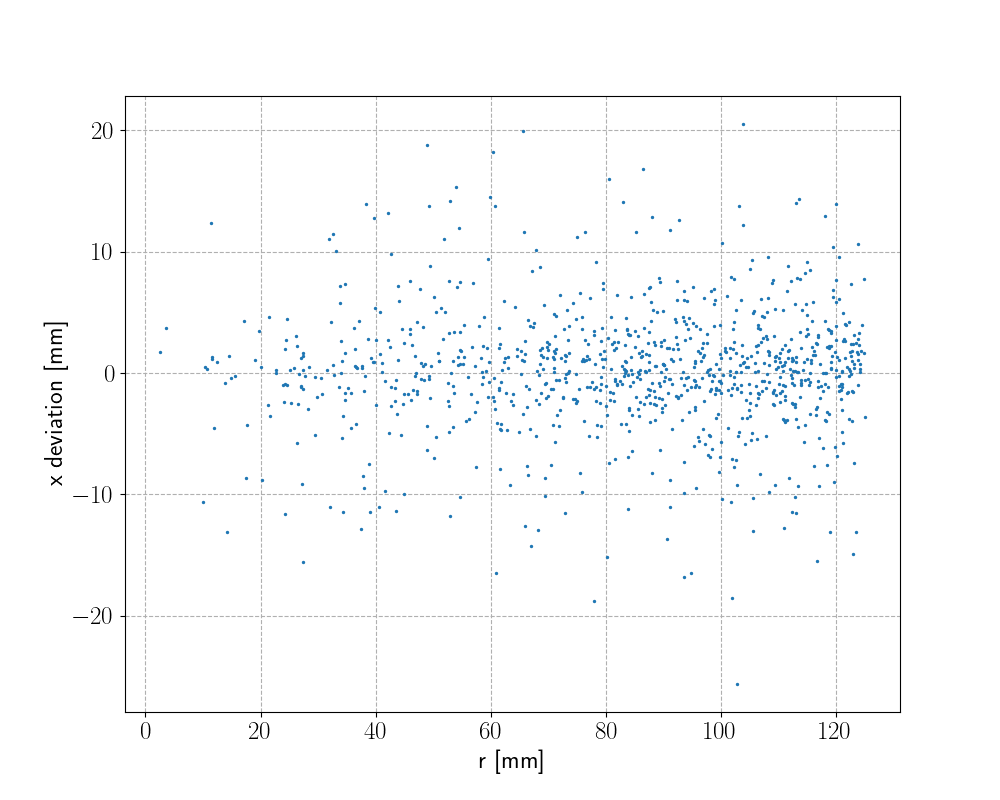

<IPython.core.display.Javascript object>


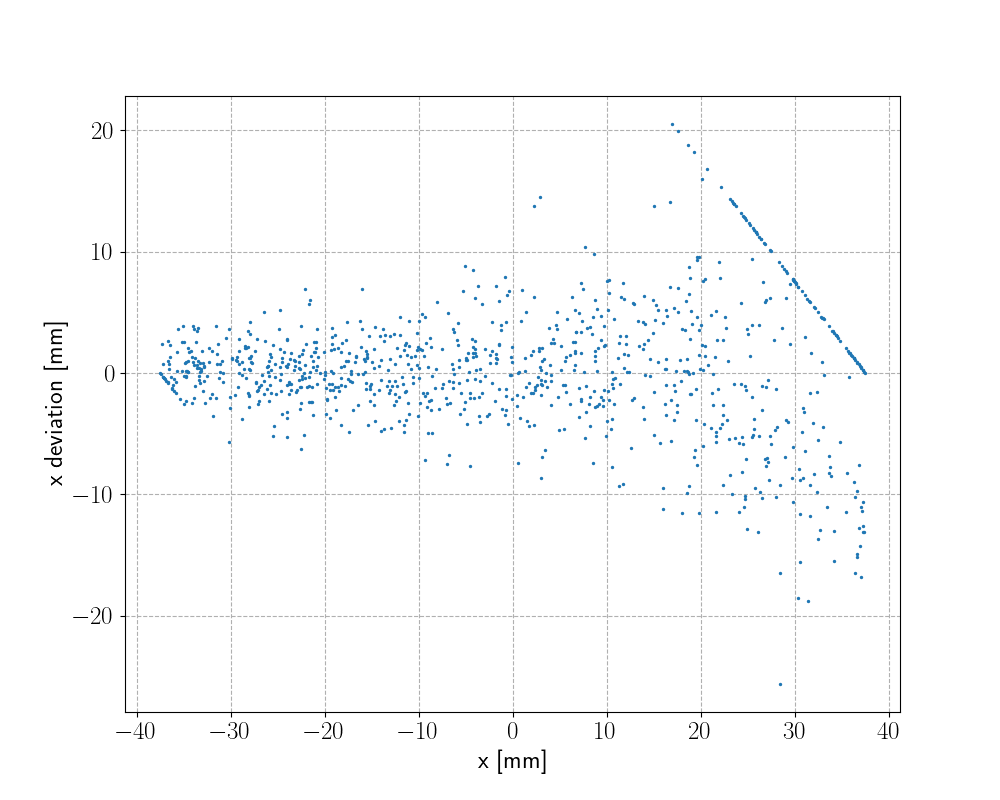

<IPython.core.display.Javascript object>


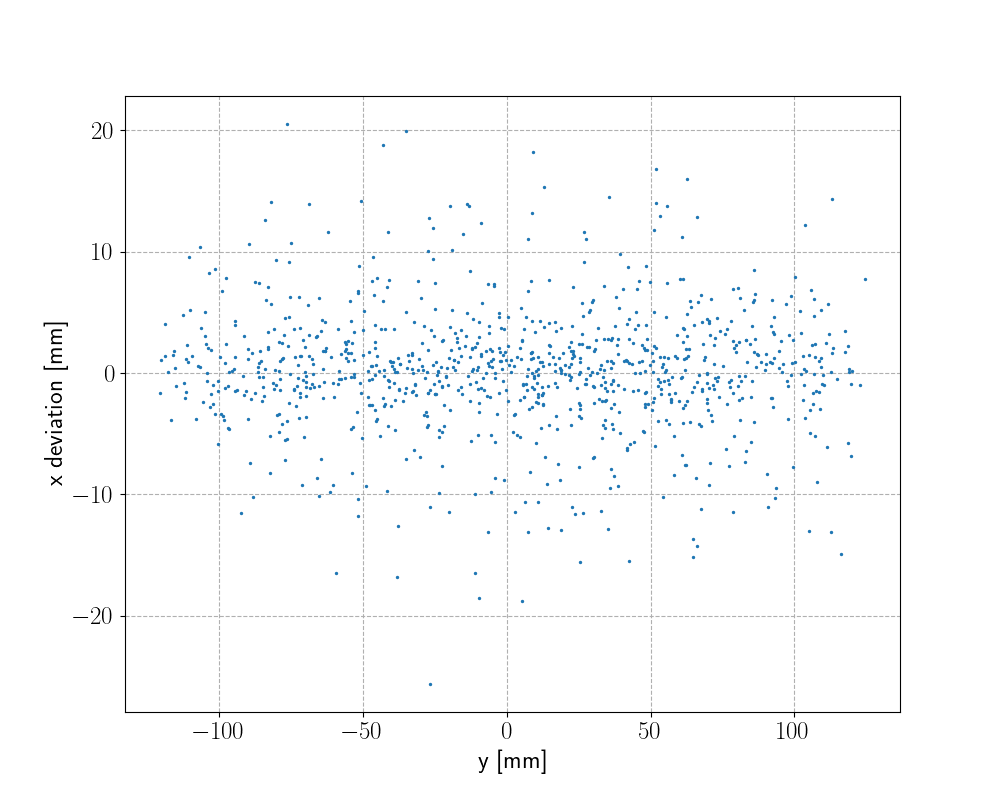

<IPython.core.display.Javascript object>


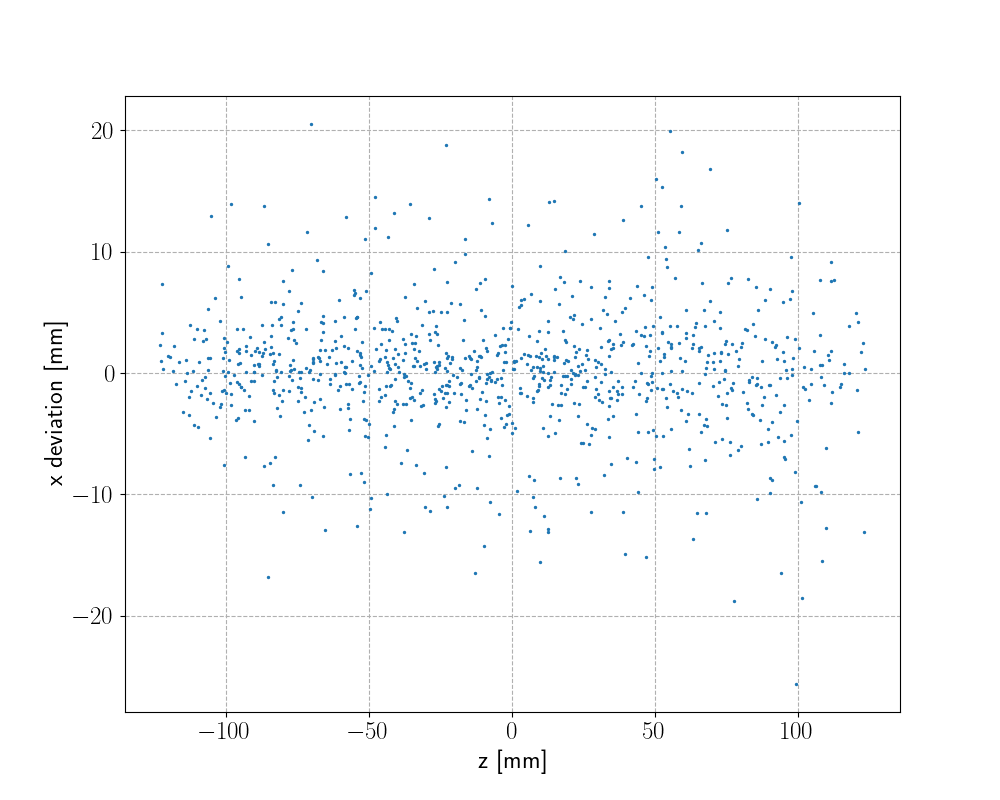

In [53]:
fig, ax = plt.subplots()
ax.scatter(test_rs, mis_xs, s=2)
ax.set_xlabel('r [mm]')
ax.set_ylabel('x deviation [mm]');

fig, ax = plt.subplots()
ax.scatter(test_points[:, 0], mis_xs, s=2)
ax.set_xlabel('x [mm]')
ax.set_ylabel('x deviation [mm]');

fig, ax = plt.subplots()
ax.scatter(test_points[:, 1], mis_xs, s=2)
ax.set_xlabel('y [mm]')
ax.set_ylabel('x deviation [mm]');

fig, ax = plt.subplots()
ax.scatter(test_points[:, 2], mis_xs, s=2)
ax.set_xlabel('z [mm]')
ax.set_ylabel('x deviation [mm]');

In [54]:
fit_point, test_points[0]

(array([-28.00111915,  34.66186019,  47.31219331]),
 array([ 26.87462294, -89.67428759, -85.25278788]))

In [55]:
75/2

37.5

In [56]:
ts = np.linspace(0, 2*np.pi, 100)
xs_n = -37.5 * np.ones_like(ts)
xs_p = 37.5 * np.ones_like(ts)
ys = 125 * np.cos(ts)
zs = 125 * np.sin(ts)
verts_n = [list(zip(xs_n, ys, zs))]
verts_p = [list(zip(xs_p, ys, zs))]
#verts_n = np.array([xs_n, ys, zs])
# verts_p = np.array([xs_p, ys, zs])

<IPython.core.display.Javascript object>


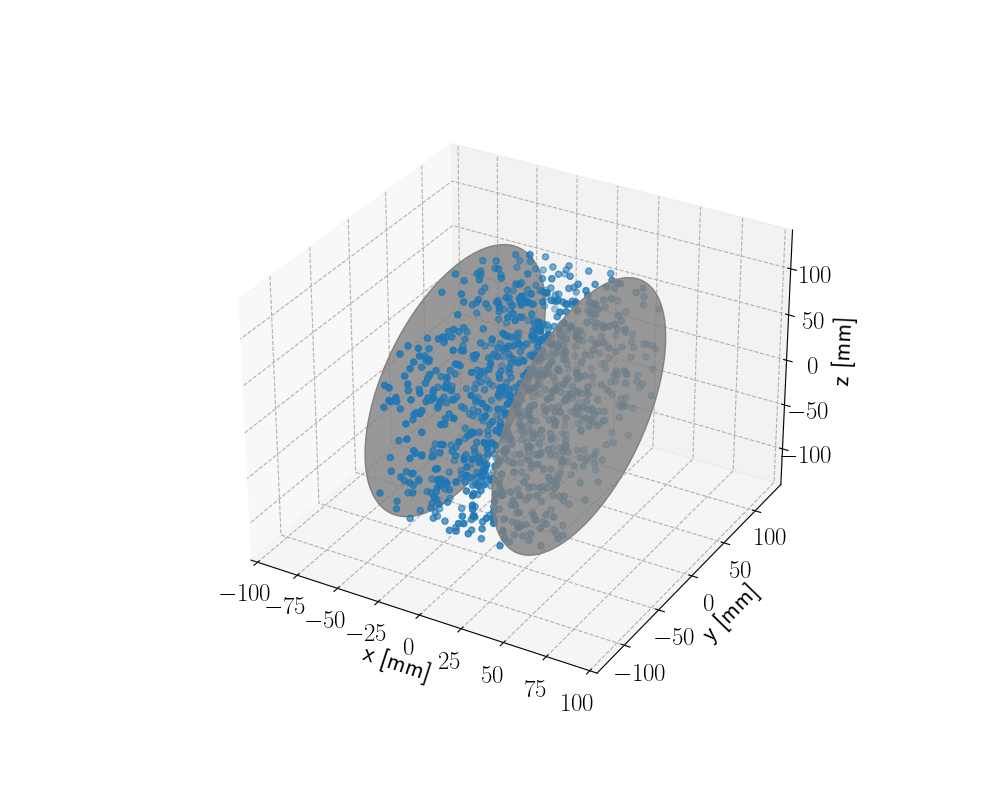

In [57]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(*test_points.T)

ax.add_collection3d(Poly3DCollection(verts_n, color='gray', alpha=0.8))#, zs='z')
ax.add_collection3d(Poly3DCollection(verts_p, color='gray', alpha=0.8))

# ax.set_aspect('equal')
ax.set_xlim3d([-100, 100])

# ax.plot_trisurf(xs_n, ys, zs, color='red', edgecolor='none');

ax.set_xlabel('x [mm]')
ax.set_ylabel('y [mm]')
ax.set_zlabel('z [mm]');

# 2D Triangulation (NMR Location)

- During first day of FNAL measurements, used mm tape measure to estimate NMR distance from brass spacers. This required also estimating the locations of the precision brass.
- All of the measurements are assumed to exist on the pole face. A correction for the sample location off of the pole can be added after the fit.
- Note that coordinate system used here has the origin at the lower left hand corner of the square s.t. the circular pole face is inscribed
- y measurements are offset by 25 mm, from the vertical 80/20 piece used to estimate spacer locations

In [58]:
def loc2dist_2d(stations, **params):
    #x0 = params['x0']
    y0 = params['y0']
    z0 = params['z0']
    #test_point = np.array([[x0, y0, z0]])
    test_point = np.array([[y0, z0]])
    return np.linalg.norm(np.subtract(stations, test_point), axis=1)

# def generate_test_points_GMW_2d(N=1):
# #     x = np.random.uniform(low=-37.5, high=37.5, size=N)
#     theta = np.random.uniform(low=0, high=2*np.pi, size=N)
#     r = 125.0*(np.random.rand(N))**(1/2)
#     y = r*np.cos(theta)
#     z = r*np.sin(theta)
#     #if N > 1:
# #     test_points = np.array([x, y, z]).T
#     test_points = np.array([y, z]).T
#     #else:
#     #    test_points = np.array([[]])
#     return test_points

def triangulate_GMW_2d(test_point, stations, noise_level=2, init_vals=[0.,0.]):
    station_meas = np.linalg.norm(np.subtract(stations, test_point), axis=1)
    station_meas_noise = station_meas + np.random.normal(loc=0, scale=noise_level, size=len(station_meas))
    model = lm.Model(loc2dist_2d, independent_vars=['stations'])
    params = lm.Parameters()

#     params.add('x0', value=init_vals[0], vary=True, min=-37.5, max=37.5)
    params.add('y0', value=init_vals[0], vary=True, min=0., max=250.)
    params.add('z0', value=init_vals[1], vary=True, min=0, max=250.)

    result = model.fit(station_meas_noise, stations=stations, params=params,
                       weights=1/(noise_level*np.ones_like(station_meas_noise)),
                       #weights=1/(station_meas_noise),
                       method='least_squares')
    fit_point = np.array([result.params[f'{i}0'].value for i in ['y', 'z']])
    
    return fit_point, result, station_meas, station_meas_noise

def triangulate_GMW_2d_data(meas_dists, stations, noise_level=2, init_vals=[0.,0.]):
    #station_meas = np.linalg.norm(np.subtract(stations, test_point), axis=1)
    #station_meas_noise = station_meas + np.random.normal(loc=0, scale=noise_level, size=len(station_meas))
    staion_meas_noise = meas_dists
    model = lm.Model(loc2dist_2d, independent_vars=['stations'])
    params = lm.Parameters()

#     params.add('x0', value=init_vals[0], vary=True, min=-37.5, max=37.5)
    params.add('y0', value=init_vals[0], vary=True, min=0., max=250.)
    params.add('z0', value=init_vals[1], vary=True, min=0., max=250.)

    result = model.fit(station_meas_noise, stations=stations, params=params,
                       weights=1/(noise_level*np.ones_like(station_meas_noise)),
                       #weights=1/(station_meas_noise),
                       method='least_squares')
    fit_point = np.array([result.params[f'{i}0'].value for i in ['y', 'z']])
    
    return fit_point, result, station_meas, station_meas_noise


# def triangulate_GMW_grid_2d(test_point, stations, noise_level=2,
#                             xs=np.linspace(-37.5, 37.5, 751),
#                             ys=np.linspace(-125., 125., 250),
#                             zs=np.linspace(-125., 125., 250)):
#     station_meas = np.linalg.norm(np.subtract(stations, test_point), axis=1)
#     station_meas_noise = station_meas + np.random.normal(loc=0, scale=noise_level, size=len(station_meas))
    
#     x_grid = []; y_grid = []; z_grid = []
#     misfit_grid = []
#     misfit_grid_noise = []
    
#     for x in xs:
#         for y in ys:
#             for z in zs:
#                 #misfit = np.linalg.norm(loc2dist(stations, x0=x, y0=y, z0=z)-station_meas_noise)**2/noise_level**2
#                 misfit_n = np.linalg.norm(loc2dist(stations, x0=x, y0=y, z0=z)-station_meas_noise)
#                 misfit_grid_noise.append(misfit_n)
#                 misfit = np.linalg.norm(loc2dist(stations, x0=x, y0=y, z0=z)-station_meas)
#                 misfit_grid.append(misfit)
#                 x_grid.append(x)
#                 y_grid.append(y)
#                 z_grid.append(z)
#     return np.array(misfit_grid), np.array(misfit_grid_noise),\
#            np.array(x_grid), np.array(y_grid), np.array(z_grid),\
#            station_meas, station_meas_noise

In [59]:
spacer_diameter = 19.33 # mm, measured with micrometer
y_offset = 25 # mm, width of 80/2, tape measure
#spacers = np.array([
# all station units mm
stations = np.array([
    [51. + spacer_diameter/2 - y_offset, 50.],
    [136. + spacer_diameter/2 - y_offset, 230. + spacer_diameter/2],
    [226. + spacer_diameter/2 - y_offset, 47.]
    #[222. + spacer_diameter/2 - y_offset, 47.] # correction from tape
    #[223. + spacer_diameter/2 - y_offset, 47.] # correction from tape
])

meas_dists = np.array([109.75, 93.31, 117.57]) + spacer_diameter/2 # mm, measured with micrometer

nmr_tape_est = np.array([125., 136.])

In [60]:
meas_dists

array([119.415, 102.975, 127.235])

In [61]:
stations

array([[ 35.665,  50.   ],
       [120.665, 239.665],
       [210.665,  47.   ]])

In [62]:
params = {'y0':125., 'z0':125.}

In [63]:
loc2dist_2d(stations, **params)

array([116.64365489, 114.74691477, 115.85547991])

In [64]:
model = lm.Model(loc2dist_2d, independent_vars=['stations'])
params = lm.Parameters()
params.add('y0', value=125., vary=True, min=0, max=250.)
params.add('z0', value=125., vary=True, min=0, max=250.)
result = model.fit(meas_dists, stations=stations, params=params)
nmr_best_fit = np.array([result.params[f'{i}0'].value for i in ['y', 'z']])

In [65]:
result

In [66]:
ts = np.linspace(0, 2*np.pi, 501)
ys = 125. + 125.*np.cos(ts)
zs = 125. + 125.*np.sin(ts)

<IPython.core.display.Javascript object>


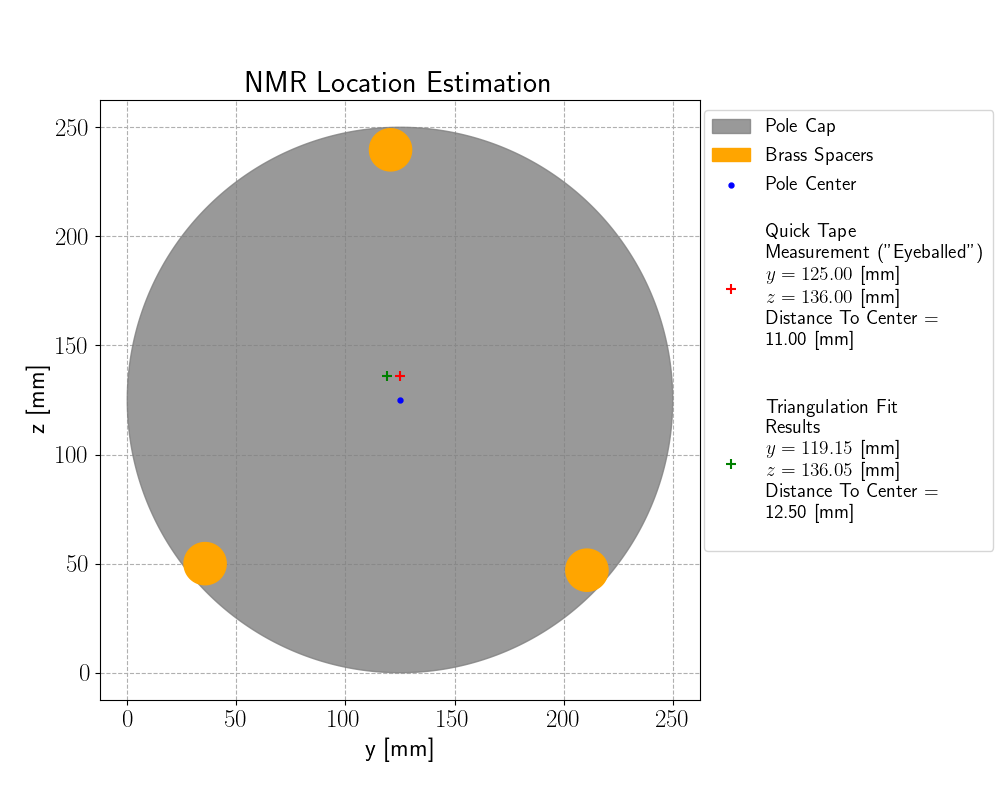

In [67]:
#fig, ax = plt.subplots()
fig = plt.figure()
ax = fig.add_axes((0.1, 0.1, 0.6, 0.8))
#ax2 = fig.add_axes((0.72, 0.08, 0.25, 0.8))

#ax.plot(ys, zs, label='Pole Cap', zorder=50)
ax.fill(ys, zs, label='Pole Cap', color='gray', alpha=0.8, zorder=50)

ax.scatter([125.], [125.], s=50, marker='.', color='blue', label='Pole Center', zorder=52)

for i, sta in enumerate(stations):
    y_ = sta[0] + spacer_diameter/2 * np.cos(ts)
    z_ = sta[1] + spacer_diameter/2 * np.sin(ts)
    l = None
    if i == 0:
        l = 'Brass Spacers'
    ax.fill(y_, z_, label=l, color='orange', zorder=51)
#ax.scatter(*stations.T, s=25, c='orange', label='Brass Spacers')
center = np.array([125., 125.])
d_est = np.linalg.norm(nmr_tape_est-center)
d_fit = np.linalg.norm(nmr_best_fit-center)

ax.scatter([nmr_tape_est[0]], [nmr_tape_est[1]], c='red', marker='+', s=50, zorder=53,
           label='\nQuick Tape\nMeasurement ("Eyeballed")\n'+rf'$y={nmr_tape_est[0]:0.2f}$'+' [mm]\n'+
          rf'$z={nmr_tape_est[1]:0.2f}$ [mm]'+'\n'+f'Distance To Center =\n{d_est:0.2f} [mm]\n')
ax.scatter([nmr_best_fit[0]], [nmr_best_fit[1]], c='green', marker='+', s=50, zorder=54,
           label='\nTriangulation Fit\nResults\n'+rf'$y={nmr_best_fit[0]:0.2f}$'+' [mm]\n'+
          rf'$z={nmr_best_fit[1]:0.2f}$ [mm]'+'\n'+f'Distance To Center =\n{d_fit:0.2f} [mm]\n')


ax.set_xlabel('y [mm]')
ax.set_ylabel('z [mm]')
ax.set_title('NMR Location Estimation')
ax.set_aspect('equal')
ax.legend(fontsize=14, bbox_to_anchor=(0.99,1.0), loc="upper left").set_zorder(100);
#ax2.legend(fontsize=14,).set_zorder(100) #bbox_to_anchor=(0.75,1.0), loc="upper left").set_zorder(100);
fig.savefig('NMR_loc.pdf', transparent=False)
fig.savefig('NMR_loc.png', transparent=False)

In [68]:
_ = triangulate_GMW_2d_data(meas_dists, stations, init_vals=[125., 125.], noise_level=1.5875)
fit_point, result, station_meas, staion_meas_noise = _

ValueError: operands could not be broadcast together with shapes (3,) (5,) 

In [69]:
#stations = np.array([[-1, -1, -1],[1, 1, 1],[-1, 1, 1],[1, -1, -1]])
#stations = np.array([[-1, -1, -1],[1, 1, 1],[-1, 1, 1],[1, -1, 1]])

# stations = np.array([[37.5, 0, 125.0], [37.5, -125.0, 0], [37.5, 0, -125.0], [37.5, 125.0, 0]])
# stations2 = np.array([[-37.5, 0, 125.0], [-37.5, -125.0, 0], [-37.5, 0, -125.0], [-37.5, 125.0, 0],])

stations = np.array([[37.5, 0, 250.0], [37.5, -125.0, 0], [37.5, 0, -125.0], [37.5, 200.0, 0]])


#stations = np.array([[37.5, 0, 125.0], [37.5, -125.0, 0], [37.5, 0, -125.0], [37.5, 125.0, 0], [-37.5, 0, 125.0]])
# stations = np.array([[37.5, 0, -125.0], [37.5, 125.0, 0], [-37.5, 0, 125.0], [37.5, -125.0, 0]])
# stations = np.array([[37.5, 0, 125.0], [37.5, -125.0, 0], [37.5, 0, -125.0], [37.5, 125.0, 0], [37.5, 88.4, 88.4]])
# stations = np.array([[37.5, 0, 125.0], [37.5, -125.0, 0], [37.5, 0, -125.0], [37.5, 125.0, 0],
#                      [-37.5, 88.4, 88.4], [-37.5, 88.4, -88.4], [-37.5, -88.4, -88.4], [-37.5, -88.4, 88.4],])
# stations = np.array([[37.5, 0, 125.0], [37.5, -125.0, 0], [37.5, 0, -125.0], [37.5, 125.0, 0],
#                      [-37.5, 0, 125.0], [-37.5, -125.0, 0], [-37.5, 0, -125.0], [-37.5, 125.0, 0],
#                      [-37.5, 88.4, 88.4], [-37.5, 88.4, -88.4], [-37.5, -88.4, -88.4], [-37.5, -88.4, 88.4],
#                      [37.5, 88.4, 88.4], [37.5, 88.4, -88.4], [37.5, -88.4, -88.4], [37.5, -88.4, 88.4],
#                      [0, 88.4, 88.4]
#                     ])

# Day 2

## Second Set of Measurements for NMR
- Marked with an "x" the location of the NMR sample within the probe head (4 mm from end). Repeated micrometer and "quick" estimate with careful location of NMR

In [70]:
spacer_diameter = 19.33 # mm, measured with micrometer
y_offset = 25 # mm, width of 80/2, tape measure
#spacers = np.array([
# all station units mm
stations = np.array([
    [51. + spacer_diameter/2 - y_offset, 50.],
    [136. + spacer_diameter/2 - y_offset, 230. + spacer_diameter/2],
    [226. + spacer_diameter/2 - y_offset, 47.]
    #[222. + spacer_diameter/2 - y_offset, 47.] # correction from tape
    #[223. + spacer_diameter/2 - y_offset, 47.] # correction from tape
])

meas_dists = np.array([112.78, 93.92, 112.69]) + spacer_diameter/2 # mm, measured with micrometer

nmr_tape_est = np.array([125., 135.]) # maybe 135.5
# nmr_tape_est = np.array([125., 135.5]) # maybe 135.5

In [71]:
meas_dists

array([122.445, 103.585, 122.355])

In [72]:
stations

array([[ 35.665,  50.   ],
       [120.665, 239.665],
       [210.665,  47.   ]])

In [73]:
params = {'y0':125., 'z0':125.}

In [74]:
loc2dist_2d(stations, **params)

array([116.64365489, 114.74691477, 115.85547991])

In [75]:
model = lm.Model(loc2dist_2d, independent_vars=['stations'])
params = lm.Parameters()
params.add('y0', value=125., vary=True, min=0, max=250.)
params.add('z0', value=125., vary=True, min=0, max=250.)
result = model.fit(meas_dists, stations=stations, params=params)
nmr_best_fit = np.array([result.params[f'{i}0'].value for i in ['y', 'z']])

In [76]:
result

In [77]:
ts = np.linspace(0, 2*np.pi, 501)
ys = 125. + 125.*np.cos(ts)
zs = 125. + 125.*np.sin(ts)

<IPython.core.display.Javascript object>


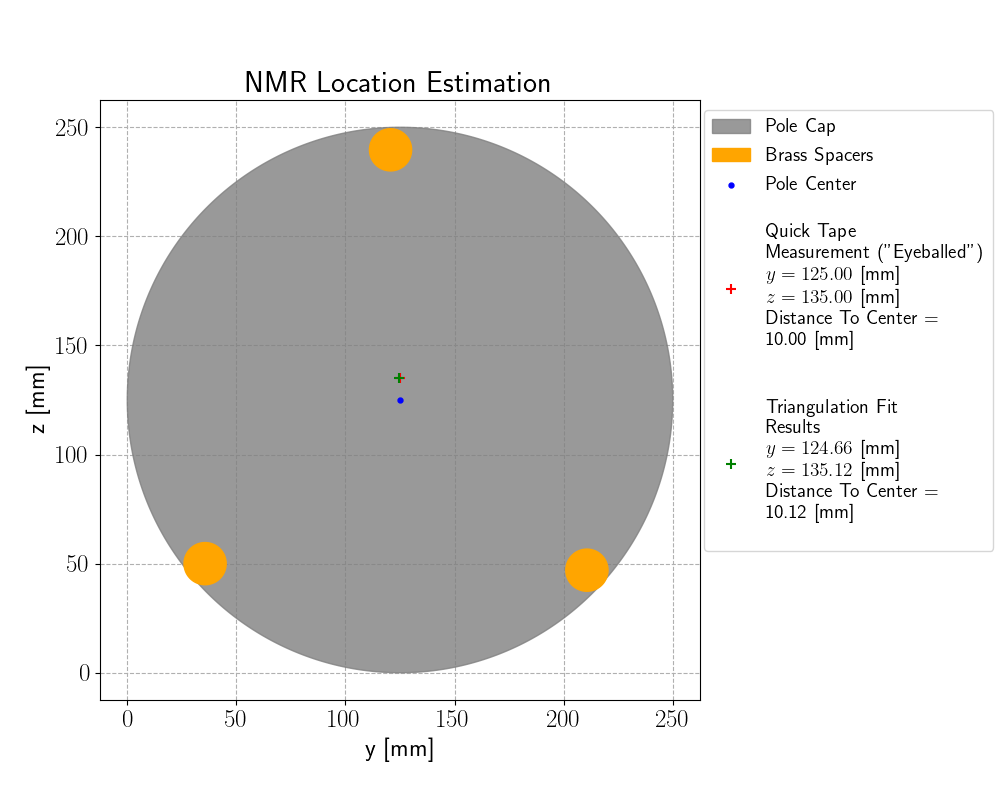

In [78]:
#fig, ax = plt.subplots()
fig = plt.figure()
ax = fig.add_axes((0.1, 0.1, 0.6, 0.8))
#ax2 = fig.add_axes((0.72, 0.08, 0.25, 0.8))

#ax.plot(ys, zs, label='Pole Cap', zorder=50)
ax.fill(ys, zs, label='Pole Cap', color='gray', alpha=0.8, zorder=50)

ax.scatter([125.], [125.], s=50, marker='.', color='blue', label='Pole Center', zorder=52)

for i, sta in enumerate(stations):
    y_ = sta[0] + spacer_diameter/2 * np.cos(ts)
    z_ = sta[1] + spacer_diameter/2 * np.sin(ts)
    l = None
    if i == 0:
        l = 'Brass Spacers'
    ax.fill(y_, z_, label=l, color='orange', zorder=51)
#ax.scatter(*stations.T, s=25, c='orange', label='Brass Spacers')
center = np.array([125., 125.])
d_est = np.linalg.norm(nmr_tape_est-center)
d_fit = np.linalg.norm(nmr_best_fit-center)

ax.scatter([nmr_tape_est[0]], [nmr_tape_est[1]], c='red', marker='+', s=50, zorder=53,
           label='\nQuick Tape\nMeasurement ("Eyeballed")\n'+rf'$y={nmr_tape_est[0]:0.2f}$'+' [mm]\n'+
          rf'$z={nmr_tape_est[1]:0.2f}$ [mm]'+'\n'+f'Distance To Center =\n{d_est:0.2f} [mm]\n')
ax.scatter([nmr_best_fit[0]], [nmr_best_fit[1]], c='green', marker='+', s=50, zorder=54,
           label='\nTriangulation Fit\nResults\n'+rf'$y={nmr_best_fit[0]:0.2f}$'+' [mm]\n'+
          rf'$z={nmr_best_fit[1]:0.2f}$ [mm]'+'\n'+f'Distance To Center =\n{d_fit:0.2f} [mm]\n')


ax.set_xlabel('y [mm]')
ax.set_ylabel('z [mm]')
ax.set_title('NMR Location Estimation')
ax.set_aspect('equal')
ax.legend(fontsize=14, bbox_to_anchor=(0.99,1.0), loc="upper left").set_zorder(100);
#ax2.legend(fontsize=14,).set_zorder(100) #bbox_to_anchor=(0.75,1.0), loc="upper left").set_zorder(100);
fig.savefig('NMR_loc_2.pdf', transparent=False)
fig.savefig('NMR_loc_2.png', transparent=False)

## Hall Probe Measurements
- Marked with an "+" the location of the Hall element behind the protective cover
- Measured distance from pole (with NMR) to Hall probe cover
- Measured distance from Hall probe cover to Hall element
- Using Hall probe cover plane (marked on each brass spacer), measured 2D distance Hall probe to brass spacer.
- Can use same 2D triangulation + add 3rd dimension measurement.

In [79]:
nmr_tape_est, nmr_best_fit

(array([125., 135.]), array([124.65620346, 135.11584042]))

In [99]:
# use the same as for NMR
'''
spacer_diameter = 19.33 # mm, measured with micrometer
y_offset = 25 # mm, width of 80/2, tape measure
#spacers = np.array([
# all station units mm
stations = np.array([
    [51. + spacer_diameter/2 - y_offset, 50.],
    [136. + spacer_diameter/2 - y_offset, 230. + spacer_diameter/2],
    [226. + spacer_diameter/2 - y_offset, 47.]
    #[222. + spacer_diameter/2 - y_offset, 47.] # correction from tape
    #[223. + spacer_diameter/2 - y_offset, 47.] # correction from tape
])
'''

meas_dists = np.array([97.51, 112.07, 105.82]) + spacer_diameter/2 # mm, measured with micrometer

# nmr_tape_est = np.array([125., 135.]) # maybe 135.5
# nmr_tape_est = np.array([125., 135.5]) # maybe 135.5

x0_hall = 30.60 # mm
x_offset_hall = 4.0 # mm

x_hall = x0_hall + x_offset_hall

In [100]:
meas_dists

array([107.175, 121.735, 115.485])

In [101]:
stations

array([[ 35.665,  50.   ],
       [120.665, 239.665],
       [210.665,  47.   ]])

In [102]:
model = lm.Model(loc2dist_2d, independent_vars=['stations'])
params = lm.Parameters()
params.add('y0', value=125., vary=True, min=0, max=250.)
params.add('z0', value=125., vary=True, min=0, max=250.)
result = model.fit(meas_dists, stations=stations, params=params)
hall_best_fit = np.array([result.params[f'{i}0'].value for i in ['y', 'z']])

In [103]:
result

In [85]:
ts = np.linspace(0, 2*np.pi, 501)
ys = 125. + 125.*np.cos(ts)
zs = 125. + 125.*np.sin(ts)

<IPython.core.display.Javascript object>


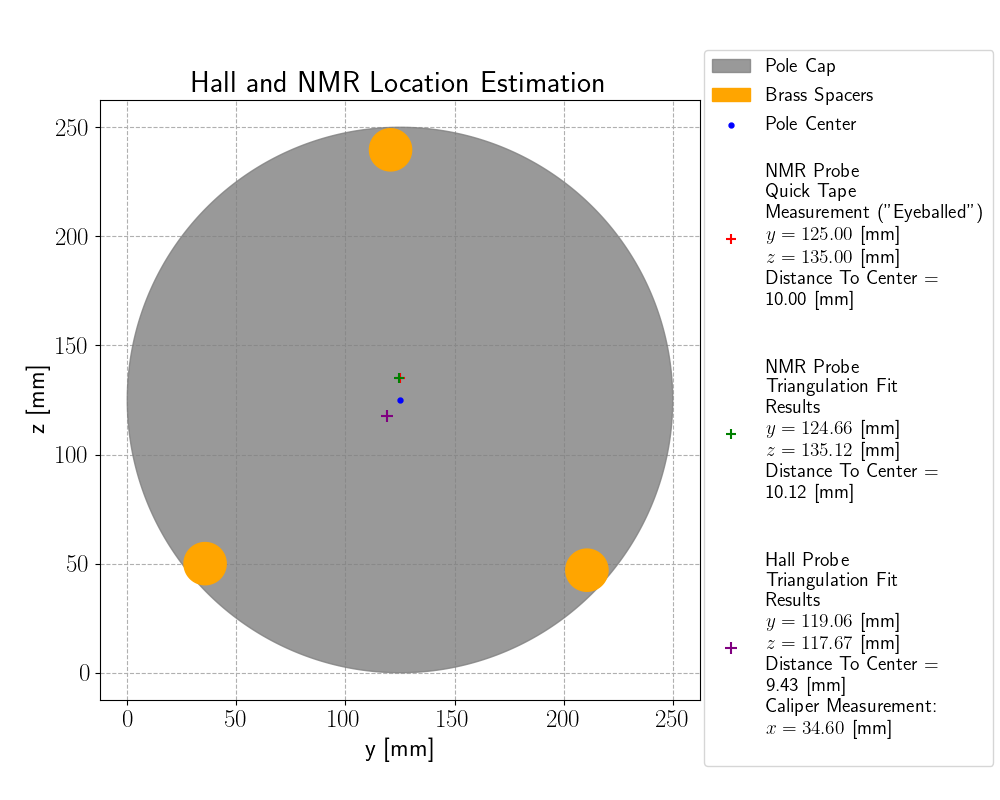

In [86]:
#fig, ax = plt.subplots()
fig = plt.figure()
ax = fig.add_axes((0.1, 0.1, 0.6, 0.8))
#ax2 = fig.add_axes((0.72, 0.08, 0.25, 0.8))

#ax.plot(ys, zs, label='Pole Cap', zorder=50)
ax.fill(ys, zs, label='Pole Cap', color='gray', alpha=0.8, zorder=50)

ax.scatter([125.], [125.], s=50, marker='.', color='blue', label='Pole Center', zorder=52)

for i, sta in enumerate(stations):
    y_ = sta[0] + spacer_diameter/2 * np.cos(ts)
    z_ = sta[1] + spacer_diameter/2 * np.sin(ts)
    l = None
    if i == 0:
        l = 'Brass Spacers'
    ax.fill(y_, z_, label=l, color='orange', zorder=51)
#ax.scatter(*stations.T, s=25, c='orange', label='Brass Spacers')
center = np.array([125., 125.])
d_est = np.linalg.norm(nmr_tape_est-center)
d_fit = np.linalg.norm(nmr_best_fit-center)
d_hall = np.linalg.norm(hall_best_fit-center)

ax.scatter([nmr_tape_est[0]], [nmr_tape_est[1]], c='red', marker='+', s=50, zorder=53,
           label='\nNMR Probe\nQuick Tape\nMeasurement ("Eyeballed")\n'+rf'$y={nmr_tape_est[0]:0.2f}$'+' [mm]\n'+
          rf'$z={nmr_tape_est[1]:0.2f}$ [mm]'+'\n'+f'Distance To Center =\n{d_est:0.2f} [mm]\n')
ax.scatter([nmr_best_fit[0]], [nmr_best_fit[1]], c='green', marker='+', s=50, zorder=54,
           label='\nNMR Probe\nTriangulation Fit\nResults\n'+rf'$y={nmr_best_fit[0]:0.2f}$'+' [mm]\n'+
          rf'$z={nmr_best_fit[1]:0.2f}$ [mm]'+'\n'+f'Distance To Center =\n{d_fit:0.2f} [mm]\n')

ax.scatter([hall_best_fit[0]], [hall_best_fit[1]], c='purple', marker='+', s=75, zorder=55,
           label='\nHall Probe\nTriangulation Fit\nResults\n'+rf'$y={hall_best_fit[0]:0.2f}$'+' [mm]\n'+
           rf'$z={hall_best_fit[1]:0.2f}$ [mm]'+'\n'+f'Distance To Center =\n{d_hall:0.2f} [mm]\n'+
           'Caliper Measurement:\n'+rf'$x = {x_hall:0.2f}$ [mm]'+'\n'
          )


ax.set_xlabel('y [mm]')
ax.set_ylabel('z [mm]')
ax.set_title('Hall and NMR Location Estimation')
ax.set_aspect('equal')
ax.legend(fontsize=14, bbox_to_anchor=(0.99,1.1), loc="upper left").set_zorder(100);
#ax2.legend(fontsize=14,).set_zorder(100) #bbox_to_anchor=(0.75,1.0), loc="upper left").set_zorder(100);
fig.savefig('Hall_and_NMR_loc_2.pdf', transparent=False)
fig.savefig('Hall_and_NMR_loc_2.png', transparent=False)

In [88]:
hall_best_fit-center

array([-5.94052964, -7.32896923])

In [89]:
37.50-34.60

2.8999999999999986

## Zaber Pole-to-Pole Measurement 06-14-21
- Measured distance to NMR sample on Zaber arm at the starting position of the pole-to-pole measurments. The aim was to put the NMR along the center of the magnet poles.

## Before Correction

In [92]:
x_offset_zaber = 12.9 - 2 + 2 # mm, Al width - NMR sample depth + Al distance from pole at start position

In [93]:
nmr_tape_est, nmr_best_fit

(array([125., 135.]), array([124.65620346, 135.11584042]))

In [172]:
# use the same as for NMR
'''
spacer_diameter = 19.33 # mm, measured with micrometer
y_offset = 25 # mm, width of 80/2, tape measure
#spacers = np.array([
# all station units mm
stations = np.array([
    [51. + spacer_diameter/2 - y_offset, 50.],
    [136. + spacer_diameter/2 - y_offset, 230. + spacer_diameter/2],
    [226. + spacer_diameter/2 - y_offset, 47.]
    #[222. + spacer_diameter/2 - y_offset, 47.] # correction from tape
    #[223. + spacer_diameter/2 - y_offset, 47.] # correction from tape
])
'''

#meas_dists = np.array([97.51, 112.07, 105.82]) + spacer_diameter/2 # mm, measured with micrometer
meas_dists = np.array([99.92, 100.17, 126.74]) + spacer_diameter/2 # mm, measured with micrometer
# TEST!!!
#meas_dists = np.array([99.92, 100.17, 110.74]) + spacer_diameter/2 # mm, measured with micrometer
# NEW LOCATION
#meas_dists = np.array([106.7, 106.05, 106.54]) + spacer_diameter/2 # mm, measured with micrometer

# nmr_tape_est = np.array([125., 135.]) # maybe 135.5
# nmr_tape_est = np.array([125., 135.5]) # maybe 135.5

x0_zaber = 12.9 - 2 + 2 # mm, Al width - NMR sample depth + Al distance from pole at start position
x_offset_zaber = 0.
#x_offset_hall = 4.0 # mm

x_zaber = x0_zaber + x_offset_zaber

In [173]:
meas_dists

array([109.585, 109.835, 136.405])

In [174]:
stations

array([[ 35.665,  50.   ],
       [120.665, 239.665],
       [210.665,  47.   ]])

In [175]:
model = lm.Model(loc2dist_2d, independent_vars=['stations'])
params = lm.Parameters()
params.add('y0', value=125., vary=True, min=0, max=250.)
params.add('z0', value=125., vary=True, min=0, max=250.)
result = model.fit(meas_dists, stations=stations, params=params)
zaber_best_fit = np.array([result.params[f'{i}0'].value for i in ['y', 'z']])

In [176]:
result

In [177]:
ts = np.linspace(0, 2*np.pi, 501)
ys = 125. + 125.*np.cos(ts)
zs = 125. + 125.*np.sin(ts)

<IPython.core.display.Javascript object>


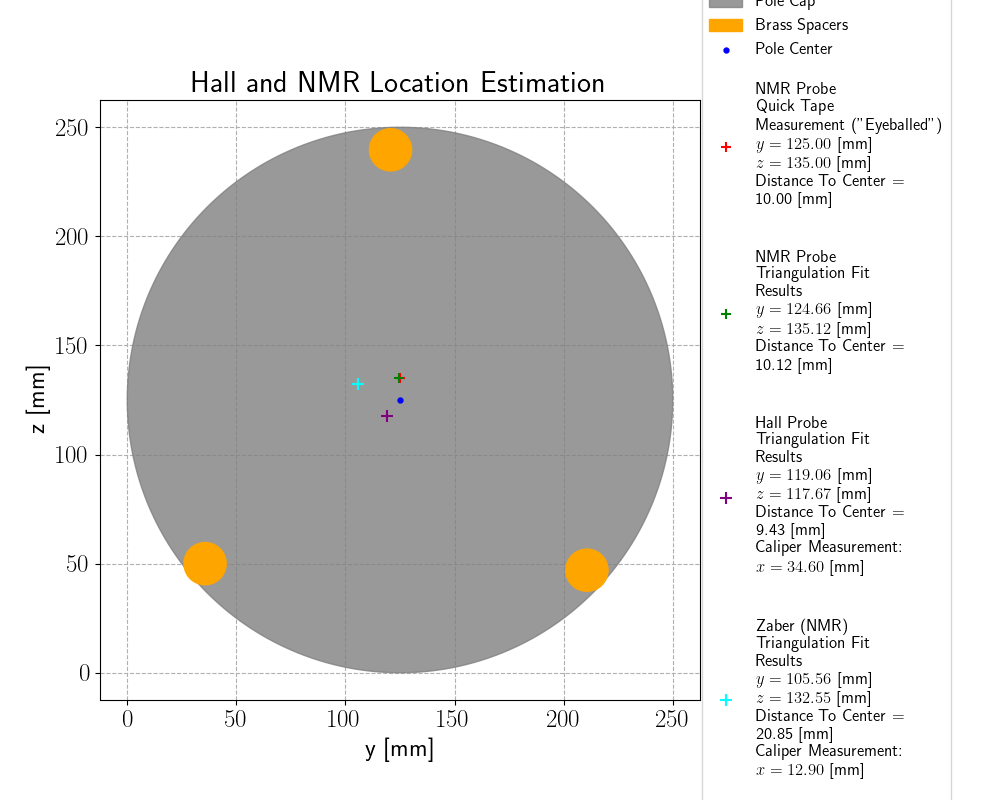

In [178]:
#fig, ax = plt.subplots()
fig = plt.figure()
ax = fig.add_axes((0.1, 0.1, 0.6, 0.8))
#ax2 = fig.add_axes((0.72, 0.08, 0.25, 0.8))

#ax.plot(ys, zs, label='Pole Cap', zorder=50)
ax.fill(ys, zs, label='Pole Cap', color='gray', alpha=0.8, zorder=50)

ax.scatter([125.], [125.], s=50, marker='.', color='blue', label='Pole Center', zorder=52)

for i, sta in enumerate(stations):
    y_ = sta[0] + spacer_diameter/2 * np.cos(ts)
    z_ = sta[1] + spacer_diameter/2 * np.sin(ts)
    l = None
    if i == 0:
        l = 'Brass Spacers'
    ax.fill(y_, z_, label=l, color='orange', zorder=51)
#ax.scatter(*stations.T, s=25, c='orange', label='Brass Spacers')
center = np.array([125., 125.])
d_est = np.linalg.norm(nmr_tape_est-center)
d_fit = np.linalg.norm(nmr_best_fit-center)
d_hall = np.linalg.norm(hall_best_fit-center)
d_zaber = np.linalg.norm(zaber_best_fit-center)

ax.scatter([nmr_tape_est[0]], [nmr_tape_est[1]], c='red', marker='+', s=50, zorder=53,
           label='\nNMR Probe\nQuick Tape\nMeasurement ("Eyeballed")\n'+rf'$y={nmr_tape_est[0]:0.2f}$'+' [mm]\n'+
          rf'$z={nmr_tape_est[1]:0.2f}$ [mm]'+'\n'+f'Distance To Center =\n{d_est:0.2f} [mm]\n')
ax.scatter([nmr_best_fit[0]], [nmr_best_fit[1]], c='green', marker='+', s=50, zorder=54,
           label='\nNMR Probe\nTriangulation Fit\nResults\n'+rf'$y={nmr_best_fit[0]:0.2f}$'+' [mm]\n'+
          rf'$z={nmr_best_fit[1]:0.2f}$ [mm]'+'\n'+f'Distance To Center =\n{d_fit:0.2f} [mm]\n')

ax.scatter([hall_best_fit[0]], [hall_best_fit[1]], c='purple', marker='+', s=75, zorder=55,
           label='\nHall Probe\nTriangulation Fit\nResults\n'+rf'$y={hall_best_fit[0]:0.2f}$'+' [mm]\n'+
           rf'$z={hall_best_fit[1]:0.2f}$ [mm]'+'\n'+f'Distance To Center =\n{d_hall:0.2f} [mm]\n'+
           'Caliper Measurement:\n'+rf'$x = {x_hall:0.2f}$ [mm]'+'\n'
          )

ax.scatter([zaber_best_fit[0]], [zaber_best_fit[1]], c='cyan', marker='+', s=75, zorder=56,
           label='\nZaber (NMR)\nTriangulation Fit\nResults\n'+rf'$y={zaber_best_fit[0]:0.2f}$'+' [mm]\n'+
           rf'$z={zaber_best_fit[1]:0.2f}$ [mm]'+'\n'+f'Distance To Center =\n{d_zaber:0.2f} [mm]\n'+
           'Caliper Measurement:\n'+rf'$x = {x_zaber:0.2f}$ [mm]'+'\n'
          )



ax.set_xlabel('y [mm]')
ax.set_ylabel('z [mm]')
ax.set_title('Hall and NMR Location Estimation')
ax.set_aspect('equal')
ax.legend(fontsize=12, bbox_to_anchor=(0.99,1.2), loc="upper left").set_zorder(100);
#ax2.legend(fontsize=14,).set_zorder(100) #bbox_to_anchor=(0.75,1.0), loc="upper left").set_zorder(100);
fig.savefig('Zaber_Hall_and_NMR_loc.pdf', transparent=False)
fig.savefig('Zaber_Hall_and_NMR_loc.png', transparent=False)

In [179]:
params

name,value,initial value,min,max,vary
y0,125.000000,125.0,0.00000000,250.000000,True
z0,125.000000,125.0,0.00000000,250.000000,True


In [180]:
loc2dist_2d(stations, **params)

array([116.64365489, 114.74691477, 115.85547991])

In [181]:
spacer_diameter/2

9.665

In [182]:
loc2dist_2d(stations, **params) - spacer_diameter/2

array([106.97865489, 105.08191477, 106.19047991])

In [183]:
hall_best_fit-center

array([-5.94052964, -7.32896923])

In [184]:
37.50-34.60

2.8999999999999986

In [185]:
zaber_best_fit - center

array([-19.44030872,   7.5487294 ])

In [186]:
y0 = 460000; z0 = 1689210 # ADC
y0mm = 160; z0mm = 100 # mm

In [187]:
yf = 366402; zf = 1629710 # ADC
yfmm = 125; zfmm = 125; # mm

In [188]:
ADC_per_mm = 2560.0

In [189]:
(yf-y0) / ADC_per_mm

-36.56171875

In [190]:
(zf-z0) / ADC_per_mm

-23.2421875

In [191]:
dy, dz = (zaber_best_fit - center) * ADC_per_mm # ADC

In [192]:
dy, dz

(-49767.190317343266, 19324.747256598566)

In [193]:
ynew = round(yf - dy)
ynew

416169

In [194]:
yf

366402

In [195]:
znew = round(zf + dz)
znew

1649035

In [196]:
# 3D grid (2 mm step)

In [197]:
25600 / 5

5120.0

In [198]:
ADC_per_mm * 2

5120.0

In [199]:
ynew - ADC_per_mm*5

403369.0

In [200]:
znew - ADC_per_mm*5

1636235.0

In [201]:
ADC_per_mm*10

25600.0

## After Correction

In [202]:
x_offset_zaber = 12.9 - 2 + 2 # mm, Al width - NMR sample depth + Al distance from pole at start position

In [203]:
nmr_tape_est, nmr_best_fit

(array([125., 135.]), array([124.65620346, 135.11584042]))

In [204]:
# use the same as for NMR
'''
spacer_diameter = 19.33 # mm, measured with micrometer
y_offset = 25 # mm, width of 80/2, tape measure
#spacers = np.array([
# all station units mm
stations = np.array([
    [51. + spacer_diameter/2 - y_offset, 50.],
    [136. + spacer_diameter/2 - y_offset, 230. + spacer_diameter/2],
    [226. + spacer_diameter/2 - y_offset, 47.]
    #[222. + spacer_diameter/2 - y_offset, 47.] # correction from tape
    #[223. + spacer_diameter/2 - y_offset, 47.] # correction from tape
])
'''

#meas_dists = np.array([97.51, 112.07, 105.82]) + spacer_diameter/2 # mm, measured with micrometer
#meas_dists = np.array([99.92, 100.17, 126.74]) + spacer_diameter/2 # mm, measured with micrometer
# TEST!!!
#meas_dists = np.array([99.92, 100.17, 110.74]) + spacer_diameter/2 # mm, measured with micrometer
# NEW LOCATION
meas_dists = np.array([106.7, 106.05, 106.54]) + spacer_diameter/2 # mm, measured with micrometer

# nmr_tape_est = np.array([125., 135.]) # maybe 135.5
# nmr_tape_est = np.array([125., 135.5]) # maybe 135.5

x0_zaber = 12.9 - 2 + 2 # mm, Al width - NMR sample depth + Al distance from pole at start position
x_offset_zaber = 0.
#x_offset_hall = 4.0 # mm

x_zaber = x0_zaber + x_offset_zaber

In [205]:
meas_dists

array([116.365, 115.715, 116.205])

In [206]:
stations

array([[ 35.665,  50.   ],
       [120.665, 239.665],
       [210.665,  47.   ]])

In [207]:
model = lm.Model(loc2dist_2d, independent_vars=['stations'])
params = lm.Parameters()
params.add('y0', value=125., vary=True, min=0, max=250.)
params.add('z0', value=125., vary=True, min=0, max=250.)
result = model.fit(meas_dists, stations=stations, params=params)
zaber_best_fit_corr = np.array([result.params[f'{i}0'].value for i in ['y', 'z']])

In [208]:
result

In [209]:
ts = np.linspace(0, 2*np.pi, 501)
ys = 125. + 125.*np.cos(ts)
zs = 125. + 125.*np.sin(ts)

<IPython.core.display.Javascript object>


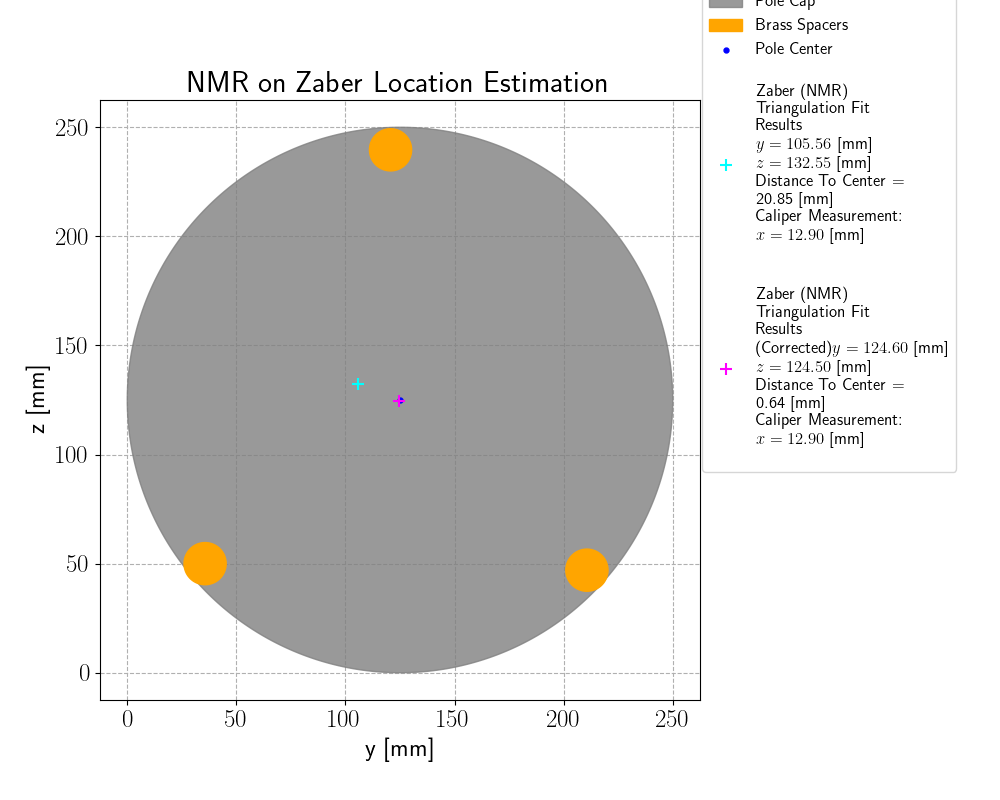

In [210]:
#fig, ax = plt.subplots()
fig = plt.figure()
ax = fig.add_axes((0.1, 0.1, 0.6, 0.8))
#ax2 = fig.add_axes((0.72, 0.08, 0.25, 0.8))

#ax.plot(ys, zs, label='Pole Cap', zorder=50)
ax.fill(ys, zs, label='Pole Cap', color='gray', alpha=0.8, zorder=50)

ax.scatter([125.], [125.], s=50, marker='.', color='blue', label='Pole Center', zorder=52)

for i, sta in enumerate(stations):
    y_ = sta[0] + spacer_diameter/2 * np.cos(ts)
    z_ = sta[1] + spacer_diameter/2 * np.sin(ts)
    l = None
    if i == 0:
        l = 'Brass Spacers'
    ax.fill(y_, z_, label=l, color='orange', zorder=51)
#ax.scatter(*stations.T, s=25, c='orange', label='Brass Spacers')
center = np.array([125., 125.])
d_est = np.linalg.norm(nmr_tape_est-center)
d_fit = np.linalg.norm(nmr_best_fit-center)
d_hall = np.linalg.norm(hall_best_fit-center)
d_zaber = np.linalg.norm(zaber_best_fit-center)
d_zaber_corr = np.linalg.norm(zaber_best_fit_corr-center)

# ax.scatter([nmr_tape_est[0]], [nmr_tape_est[1]], c='red', marker='+', s=50, zorder=53,
#            label='\nNMR Probe\nQuick Tape\nMeasurement ("Eyeballed")\n'+rf'$y={nmr_tape_est[0]:0.2f}$'+' [mm]\n'+
#           rf'$z={nmr_tape_est[1]:0.2f}$ [mm]'+'\n'+f'Distance To Center =\n{d_est:0.2f} [mm]\n')
# ax.scatter([nmr_best_fit[0]], [nmr_best_fit[1]], c='green', marker='+', s=50, zorder=54,
#            label='\nNMR Probe\nTriangulation Fit\nResults\n'+rf'$y={nmr_best_fit[0]:0.2f}$'+' [mm]\n'+
#           rf'$z={nmr_best_fit[1]:0.2f}$ [mm]'+'\n'+f'Distance To Center =\n{d_fit:0.2f} [mm]\n')

# ax.scatter([hall_best_fit[0]], [hall_best_fit[1]], c='purple', marker='+', s=75, zorder=55,
#            label='\nHall Probe\nTriangulation Fit\nResults\n'+rf'$y={hall_best_fit[0]:0.2f}$'+' [mm]\n'+
#            rf'$z={hall_best_fit[1]:0.2f}$ [mm]'+'\n'+f'Distance To Center =\n{d_hall:0.2f} [mm]\n'+
#            'Caliper Measurement:\n'+rf'$x = {x_hall:0.2f}$ [mm]'+'\n'
#           )

ax.scatter([zaber_best_fit[0]], [zaber_best_fit[1]], c='cyan', marker='+', s=75, zorder=56,
           label='\nZaber (NMR)\nTriangulation Fit\nResults\n'+rf'$y={zaber_best_fit[0]:0.2f}$'+' [mm]\n'+
           rf'$z={zaber_best_fit[1]:0.2f}$ [mm]'+'\n'+f'Distance To Center =\n{d_zaber:0.2f} [mm]\n'+
           'Caliper Measurement:\n'+rf'$x = {x_zaber:0.2f}$ [mm]'+'\n'
          )

ax.scatter([zaber_best_fit_corr[0]], [zaber_best_fit_corr[1]], c='magenta', marker='+', s=75, zorder=56,
           label='\nZaber (NMR)\nTriangulation Fit\nResults\n(Corrected)'+rf'$y={zaber_best_fit_corr[0]:0.2f}$'+' [mm]\n'+
           rf'$z={zaber_best_fit_corr[1]:0.2f}$ [mm]'+'\n'+f'Distance To Center =\n{d_zaber_corr:0.2f} [mm]\n'+
           'Caliper Measurement:\n'+rf'$x = {x_zaber:0.2f}$ [mm]'+'\n'
          )



ax.set_xlabel('y [mm]')
ax.set_ylabel('z [mm]')
ax.set_title('NMR on Zaber Location Estimation')
ax.set_aspect('equal')
ax.legend(fontsize=12, bbox_to_anchor=(0.99,1.2), loc="upper left").set_zorder(100);
#ax2.legend(fontsize=14,).set_zorder(100) #bbox_to_anchor=(0.75,1.0), loc="upper left").set_zorder(100);
fig.savefig('Zaber_NMR_loc_corr.pdf', transparent=False)
fig.savefig('Zaber_NMR_loc_corr.png', transparent=False)